### TERRA-REF Season 4 Preprocessing
C. Lisle, Knowledgevis, LLC

Copyright © 2020 KnowledgeVis, LLC. All Rights Reserved.

Redistribution and use, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
2. The name of the author may not be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY KNOWLEDGEVIS, LLC "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import pandas as pd
import altair as alt

In [2]:
# we will use this function later in the notebook
def returnUniqueCounts(dframe):
    return pd.DataFrame.from_records([(col, dframe[col].nunique()) for col in dframe.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

Read in the CSV file that was created using an R procedure.  TERRA-REF publishes how to query through an R interface, so I used this process to generate the CSV.  Then the CSV is read in below and processing continues using Python and PANDAS.  The CSV file is an R "long type" where each measurement is in its own row, under the heading "trait" and its value is in the corresponding "mean" column. 

In [3]:
s4_df = pd.read_csv('/Users/curtislisle/Dropbox/ipython-notebooks/D3M/TERRA/terraref_r/season4date.csv')

/Users/curtislisle/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,32,35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
s4_df.head()['sitename']

0     MAC Field Scanner Season 4 Range 8 Column 8
1     MAC Field Scanner Season 4 Range 8 Column 9
2    MAC Field Scanner Season 4 Range 8 Column 10
3    MAC Field Scanner Season 4 Range 8 Column 12
4     MAC Field Scanner Season 4 Range 9 Column 3
Name: sitename, dtype: object

**There are duplicate sensor readings at each location** Note how, in addition to the sitenames above, there is an E and W postfix on only some entries.  Others have the range & column without an E/W tag.  The dictionary operation below was developed before noticing the same location occurs multiple times.  The long-to-wide conversion below is throwing away this separate sensor data and keeping only the last encountered value through over-writing.  **TO DO** we should modify this in the future to not lose the multiple sensor feeds or merge them to be the mean value. We will explore this more below.  It appears that there are duplicate entries as well (see range=20, col=8, 6/14/17, which occurs 3 times with 3 distinct values.  More investigation will be needed later.

In [5]:
eastern = s4_df.loc[s4_df.sitename.str.contains('E')]
print(eastern.shape)
eastern.head()['sitename']


(12525, 40)


330     MAC Field Scanner Season 4 Range 20 Column 8 E
9384     MAC Field Scanner Season 4 Range 9 Column 3 E
9385     MAC Field Scanner Season 4 Range 9 Column 3 E
9386     MAC Field Scanner Season 4 Range 9 Column 3 E
9390    MAC Field Scanner Season 4 Range 10 Column 4 E
Name: sitename, dtype: object

In [6]:
western = s4_df.loc[s4_df.sitename.str.contains('W')]
print(western.shape)
western.head()['sitename']

(13575, 40)


9387     MAC Field Scanner Season 4 Range 9 Column 3 W
9388     MAC Field Scanner Season 4 Range 9 Column 3 W
9389     MAC Field Scanner Season 4 Range 9 Column 3 W
9393    MAC Field Scanner Season 4 Range 10 Column 4 W
9394    MAC Field Scanner Season 4 Range 10 Column 4 W
Name: sitename, dtype: object

Let us look to see if the unmarked columns are the mean of the E/W columns.  It appears that not all traits have averaged values.  leaf_temperature seems to only exist in the E/W form

In [7]:
eastern[['trans_date','sitename','trait','mean']].head(8)

,trans_date,sitename,trait,mean
330,2017-06-28 14:42:00,MAC Field Scanner Season 4 Range 20 Column 8 E,leaf_temperature,305.55
9384,2017-06-14 06:08:00,MAC Field Scanner Season 4 Range 9 Column 3 E,leaf_temperature,282.25
9385,2017-06-14 06:08:00,MAC Field Scanner Season 4 Range 9 Column 3 E,leaf_temperature,282.35
9386,2017-06-14 06:08:00,MAC Field Scanner Season 4 Range 9 Column 3 E,leaf_temperature,282.65
9390,2017-06-14 06:21:00,MAC Field Scanner Season 4 Range 10 Column 4 E,leaf_temperature,284.65
9391,2017-06-14 06:21:00,MAC Field Scanner Season 4 Range 10 Column 4 E,leaf_temperature,285.05
9392,2017-06-14 06:21:00,MAC Field Scanner Season 4 Range 10 Column 4 E,leaf_temperature,285.75
9396,2017-06-14 07:02:00,MAC Field Scanner Season 4 Range 40 Column 15 E,leaf_temperature,289.95


In [8]:
western[['trans_date','sitename','trait','mean']].head(8)

,trans_date,sitename,trait,mean
9387,2017-06-14 06:08:00,MAC Field Scanner Season 4 Range 9 Column 3 W,leaf_temperature,282.05
9388,2017-06-14 06:08:00,MAC Field Scanner Season 4 Range 9 Column 3 W,leaf_temperature,282.15
9389,2017-06-14 06:08:00,MAC Field Scanner Season 4 Range 9 Column 3 W,leaf_temperature,282.25
9393,2017-06-14 06:21:00,MAC Field Scanner Season 4 Range 10 Column 4 W,leaf_temperature,283.55
9394,2017-06-14 06:21:00,MAC Field Scanner Season 4 Range 10 Column 4 W,leaf_temperature,283.75
9395,2017-06-14 06:21:00,MAC Field Scanner Season 4 Range 10 Column 4 W,leaf_temperature,284.05
9399,2017-06-14 07:02:00,MAC Field Scanner Season 4 Range 40 Column 15 W,leaf_temperature,288.65
9400,2017-06-14 07:02:00,MAC Field Scanner Season 4 Range 40 Column 15 W,leaf_temperature,288.85


In [9]:
matching = s4_df.loc[s4_df.sitename.str.contains('Range 9 Column 3') & s4_df.trait.str.contains('leaf_temperature')]
#matching = s4_df.loc[s4_df.sitename.str.contains('Range 4 Column 3')].head(8)
matching[['trans_date','sitename','trait','mean']].head(10)

,trans_date,sitename,trait,mean
9384,2017-06-14 06:08:00,MAC Field Scanner Season 4 Range 9 Column 3 E,leaf_temperature,282.25
9385,2017-06-14 06:08:00,MAC Field Scanner Season 4 Range 9 Column 3 E,leaf_temperature,282.35
9386,2017-06-14 06:08:00,MAC Field Scanner Season 4 Range 9 Column 3 E,leaf_temperature,282.65
9387,2017-06-14 06:08:00,MAC Field Scanner Season 4 Range 9 Column 3 W,leaf_temperature,282.05
9388,2017-06-14 06:08:00,MAC Field Scanner Season 4 Range 9 Column 3 W,leaf_temperature,282.15
9389,2017-06-14 06:08:00,MAC Field Scanner Season 4 Range 9 Column 3 W,leaf_temperature,282.25
9408,2017-06-14 11:41:00,MAC Field Scanner Season 4 Range 9 Column 3 E,leaf_temperature,301.35
9409,2017-06-14 11:41:00,MAC Field Scanner Season 4 Range 9 Column 3 E,leaf_temperature,301.55
9410,2017-06-14 11:41:00,MAC Field Scanner Season 4 Range 9 Column 3 E,leaf_temperature,301.55
9411,2017-06-14 11:41:00,MAC Field Scanner Season 4 Range 9 Column 3 W,leaf_temperature,302.55


In [10]:
matching = s4_df.loc[s4_df.sitename.str.contains('Range 9 Column 3') & s4_df.trait.str.contains('canopy_height') & s4_df.trans_date.str.contains('-06-14')]
print(matching.shape)
matching[['trans_date','sitename','trait','mean']]

(1, 40)


,trans_date,sitename,trait,mean
286147,2017-06-14 22:00:00,MAC Field Scanner Season 4 Range 9 Column 3 E,canopy_height,107.0


Examining the dates closely in the cell below, it appears that measurements taken with an E/W at the end are taken on different days than the ones without a direction.  This debunks the theory that the non-qualified measurements are composed from the actual, directional measurements.  Putting further analysis off until later. 

In [11]:
matching = s4_df.loc[s4_df.sitename.str.contains('Range 9 Column 3') & s4_df.trait.str.contains('canopy_height') ]
# this term forces only the e/W entries to show: 
#    & (s4_df.sitename.str.len()>=45)
print(matching.shape)
matching[['trans_date','sitename','trait','mean']]

(21, 40)


,trans_date,sitename,trait,mean
4,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,14.0
863,2017-05-16 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,19.0
1202,2017-05-18 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,21.0
1357,2017-05-19 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,22.0
1696,2017-05-20 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,23.0
2096,2017-05-25 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,38.0
2788,2017-06-04 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,80.0
3117,2017-06-05 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,84.0
3420,2017-06-06 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,88.0
3976,2017-06-09 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,97.0


Make a subset of the columns suitable for long to wide conversion

In [12]:
selected = ['id','cultivar','cultivar_id','date','trans_date','sitename','trait','mean','units']
s4sel = s4_df[selected]

In [13]:
s4sel.head()

,id,cultivar,cultivar_id,date,trans_date,sitename,trait,mean,units
0,6004764469,PI570145,6000000961,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 8 Column 8,canopy_height,13.0,cm
1,6004764470,PI329510,6000000577,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 8 Column 9,canopy_height,14.0,cm
2,6004764471,PI510757,6000000850,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 8 Column 10,canopy_height,12.0,cm
3,6004764473,PI329865,6000000815,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 8 Column 12,canopy_height,13.0,cm
4,6004764478,PI569457,6000000935,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,14.0,cm


 If all the measurements were equally distributed, doing a long to wide rollup mechanically using pandas' pivot would work.  However, some measurements started later and ended earlier.  Some measurements are daily, some are hourly (just in August), so we really need to split up this dataset into major subsets:  daily and hourly, then try to pivot these datasets.  Or worse, have to hand convert the entries.  I elected to just write a custom algorithm to gather all the measurements together, indexed by date. 

Write a routine that pivots/rolls up the data by hand, by creating a dictionary with trans_date as its index.  Then we can add measurements one at a time...  This takes a few minutes to run on a circa-2020 CPU.  There is an update line printed every 50k entries processed.  As of when this was released, there were 372k entries total. 

In [14]:
s4hand = {}
count = 0
for i in range(len(s4sel)):
    #if count > 40:
    #    break
    #print(i,s4sel['trans_date'][i])
    
    # if we have never seen this date before, start a new dictionary at this date
    if s4sel['trans_date'][i] not in s4hand.keys():
        s4hand[s4sel['trans_date'][i]] = {}

    # if we have not seen this cultivar before on this date, then add a dictionary for this cultivar.  Is there is a chance we 
    # might lose records here? 
    if s4sel['cultivar_id'][i] not in s4hand[s4sel['trans_date'][i]].keys():
        s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]] = {}
        
    # add this feature to the dictionary for the correct cultivar on this date.  We add a dictionary entry named 
    # from the contents in the 'trait' attribute and pull the value from the 'mean' attribute.  This is the heart
    # of the long to wide format conversion.
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]][s4sel['trait'][i]] = s4sel['mean'][i]
    
    # add the cultivar and the location (split out from the sitename text).  This will be added multiple times,
    # so represents redundant processing, but it works to place the measurements in cultivar and location
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['cultivar_id'] = s4sel['cultivar_id'][i]
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['cultivar'] = s4sel['cultivar'][i]
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['season'] = int(s4sel['sitename'][i].split(' ')[4])
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['range'] = int(s4sel['sitename'][i].split(' ')[6])
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['column'] = int(s4sel['sitename'][i].split(' ')[8])
    count += 1
    if (count % 50000) == 0:
        print('in process:',count, 'records ingested so far')
print('entered ',count, 'measurements')


in process: 50000 records ingested so far
in process: 100000 records ingested so far
in process: 150000 records ingested so far
in process: 200000 records ingested so far
in process: 250000 records ingested so far
in process: 300000 records ingested so far
in process: 350000 records ingested so far
entered  372363 measurements


Save out the dictionary, since it took several minutes to run. This way the notebook could be resumed by restoring this dictionary to save time later.  The immediately following cell is a restore of the pickled dictionary.  Either or both of the next two cells can be skipped if the dictionary is current and you don't want to save it out for later. 

In [15]:
import pickle 
file_dict_save = open('season4-readings-dict-by-date.obj', 'wb') 
pickle.dump(s4hand, file_dict_save)

In [1]:
import pickle 
filehandler = open('season4-readings-dict-by-date.obj', 'rb') 
s4hand = pickle.load(filehandler)

Now continue with the exploration of the dictionary, now that entries are organized by date. 

In [16]:
print('how many different datetime events:')
print(len(s4hand.keys()))
#print(s4hand.keys())
print('print ouf the wide tuple of a particular cultivar at a particular datetime:')
print(s4hand['2017-07-08 12:00:00'][6000000861])
print(s4hand['2017-08-08 12:00:00'][6000000861])

how many different datetime events:
3152
print ouf the wide tuple of a particular cultivar at a particular datetime:
{'canopy_height': 192.0, 'cultivar_id': 6000000861, 'cultivar': 'PI526905', 'season': 4, 'range': 46, 'column': 3, 'leaf_angle_mean': 0.46521782152400004, 'leaf_angle_alpha': 1.6835253597400002, 'leaf_angle_beta': 1.4356619889500002, 'leaf_angle_chi': 1.71004921126}
{'canopy_height': 293.0, 'cultivar_id': 6000000861, 'cultivar': 'PI526905', 'season': 4, 'range': 46, 'column': 3, 'leaf_angle_mean': 0.460059049579, 'leaf_angle_alpha': 1.80939043311, 'leaf_angle_beta': 1.5116882921700001, 'leaf_angle_chi': 1.7059298014200002}


So, at this point, we have a dictionary (s4hand) which has keys for each different datetime a measurement was entered.  There are 3152 different datetime entries.  This includes all the dates in August where hand measurements are made.  This dictionary can't be scanned easily in datetime order, but it has accumulated all the tuples.  A single dataframe could be made from this dictionary, but a lot of the entries would be empty, since most datetime entries only contain a subset of the measurements. Measurements are not always at the same time increments, either. The canopy_height and leaf properties, for the most part, are sampled once per day.  These are the only measurements that cover most of the growing season.

If the tuples were the same size, we could generate a full pandas dataframe from this dictionary, using the datetime as the index.  However, some tuples are wider than others, since not all measurements were made each time. After reviewing this data distribution, it seems best to create subdictionaries for a certain date range with consistent entries, and then convert the subdictionaries to dataframes.  This manual process is slow, but it will generate a few small, easier to explore and train on datasets.

In [17]:
for i in s4hand.keys():
    if i >= '2017-08-01' and i <= '2017-08-03':
        print(i)

2017-08-02 12:00:00
2017-08-02 13:34:00
2017-08-02 13:32:00
2017-08-02 12:10:00
2017-08-02 12:09:00
2017-08-02 11:03:00
2017-08-02 11:01:00
2017-08-02 13:28:00
2017-08-02 13:46:00
2017-08-02 13:45:00
2017-08-02 13:43:00
2017-08-02 13:42:00
2017-08-02 13:38:00
2017-08-02 12:01:00
2017-08-02 11:16:00
2017-08-02 11:13:00
2017-08-02 13:31:00
2017-08-02 12:14:00
2017-08-02 12:13:00
2017-08-02 12:11:00
2017-08-02 12:08:00
2017-08-02 11:07:00
2017-08-02 11:05:00
2017-08-02 11:00:00
2017-08-02 13:36:00
2017-08-02 13:35:00
2017-08-02 13:33:00
2017-08-02 10:26:00
2017-08-02 10:29:00
2017-08-02 10:30:00
2017-08-02 10:36:00
2017-08-02 10:42:00
2017-08-02 10:49:00
2017-08-02 10:55:00
2017-08-02 11:29:00
2017-08-02 11:31:00
2017-08-02 11:34:00
2017-08-02 11:41:00
2017-08-02 11:45:00
2017-08-02 11:46:00
2017-08-02 11:51:00
2017-08-02 11:53:00
2017-08-02 11:54:00
2017-08-02 11:57:00
2017-08-02 12:20:00
2017-08-02 12:33:00
2017-08-02 12:34:00
2017-08-02 12:53:00
2017-08-02 13:01:00
2017-08-02 13:03:00


So August 2nd at noon (not August 1st) is when measurements started being taken every few minutes.  Lets look at a few measurements.  Measurements are organized as a dictionary with keys corresponding to the dates a measurment was taken. Each entry is itself a dictionary with cultivar_id as the key and the value is the "wide format" tuple of what measurements were encountered for that cultivar and time. 

The cultivar_id is a long integer.  This is a dual key to the cultivar name we are used to seeing. Both the ID and the name are used below.  This notebook was originally designed using only the integer IDs, but this didn't match the genetic information, so this notebook has been updated to carry the cultivar name (e.g. "PI536905", etc. ) along, though indexing in the original dictarionary structure is by ID.  Later in this notebook, a cross reference table is built. 

In [18]:
print('there are', len(s4hand['2017-08-02 13:52:00'][6000000962].keys()), 'keys in this observation:')
s4hand['2017-08-02 13:52:00']

there are 43 keys in this observation:


{6000000962: {'absorbance_850': 0.41700000000000004,
  'cultivar_id': 6000000962,
  'cultivar': 'PI570254',
  'season': 4,
  'range': 45,
  'column': 4,
  'roll': -14.82,
  'PhiNO': 0.14400000000000002,
  'PhiNPQ': 0.6,
  'absorbance_530': 1.2,
  'absorbance_605': 1.466,
  'absorbance_730': 0.376,
  'absorbance_880': 0.46,
  'absorbance_940': 0.46,
  'Fs': 4298.7,
  'NPQt': 4.154,
  'qL': 0.363,
  'qP': 0.526,
  'RFd': 0.344,
  'SPAD_530': 73.96,
  'SPAD_605': 100.57,
  'SPAD_730': -8.39,
  'leaf_thickness': 0.28,
  'ambient_humidity': 39.557617,
  'leaf_angle_clamp_position': 14.87,
  'pitch': -1.28,
  'proximal_air_temperature': 40.139998999999996,
  'FvP/FmP': 0.486,
  'gH+': 0.0,
  'ECSt': 0.0,
  'leaf_temperature_differential': -6.329999,
  'Phi2': 0.256,
  'relative_chlorophyll': 48.84512428,
  'FmPrime': 5777.98,
  'FoPrime': 2968.0,
  'LEF': 174.076,
  'SPAD_420': 164.67,
  'SPAD_650': 48.85,
  'SPAD_850': -4.34,
  'SPAD_880': 0.01,
  'light_intensity_PAR': 1511.0,
  'vH+': 0.0

In [19]:
print('there are', len(s4hand['2017-08-02 13:53:00'][6000000962].keys()), 'keys in this observation:')
s4hand['2017-08-02 13:53:00']

there are 26 keys in this observation:


{6000000962: {'absorbance_850': 0.41200000000000003,
  'cultivar_id': 6000000962,
  'cultivar': 'PI570254',
  'season': 4,
  'range': 45,
  'column': 4,
  'roll': 28.54,
  'PhiNO': 0.221,
  'PhiNPQ': 0.54,
  'absorbance_530': 1.094,
  'absorbance_605': 1.348,
  'absorbance_730': 0.36200000000000004,
  'absorbance_880': 0.461,
  'absorbance_940': 0.457,
  'Fs': 5446.8,
  'NPQt': 2.447,
  'qL': 0.222,
  'qP': 0.408,
  'RFd': 0.314,
  'SPAD_530': 63.77,
  'SPAD_605': 89.11,
  'SPAD_730': -9.46,
  'leaf_thickness': 0.25,
  'ambient_humidity': 39.856445,
  'leaf_angle_clamp_position': 32.96,
  'pitch': 17.23}}

In [20]:
print('there are', len(s4hand['2017-08-02 13:11:00'][6000000851].keys()), 'keys in this observation:')
s4hand['2017-08-02 13:11:00']

there are 42 keys in this observation:


{6000000851: {'absorbance_850': 0.396,
  'cultivar_id': 6000000851,
  'cultivar': 'PI511355',
  'season': 4,
  'range': 26,
  'column': 15,
  'roll': -55.82,
  'PhiNO': 0.195,
  'PhiNPQ': 0.51,
  'absorbance_530': 1.131,
  'absorbance_605': 1.374,
  'absorbance_730': 0.35700000000000004,
  'absorbance_880': 0.446,
  'absorbance_940': 0.441,
  'Fs': 4951.5,
  'NPQt': 2.617,
  'qL': 0.31,
  'qP': 0.513,
  'RFd': 0.418,
  'SPAD_530': 69.06,
  'SPAD_605': 93.29,
  'SPAD_730': -8.34,
  'leaf_thickness': 0.1,
  'ambient_humidity': 39.974609,
  'leaf_angle_clamp_position': 57.04,
  'pitch': 14.43,
  'proximal_air_temperature': 39.82,
  'FvP/FmP': 0.574,
  'gH+': 5.7015,
  'ECSt': 0.0012,
  'leaf_temperature_differential': -1.63,
  'Phi2': 0.295,
  'relative_chlorophyll': 46.43594646,
  'FmPrime': 7021.161999999999,
  'FoPrime': 2989.0,
  'LEF': 141.406,
  'SPAD_420': 158.94,
  'SPAD_650': 46.44,
  'SPAD_850': -4.48,
  'SPAD_880': 0.47,
  'light_intensity_PAR': 1066.0,
  'vH+': 0.00020228}}

Sometimes the cultivar numeric index is used as the cultivar_id, sometimes it has the character name (e.g. 'cultivar_id': 6000000962,
  'cultivar': 'PI570254').  Hand measurements during August seem to have the cultivar_id entered as the cultivar, so build a cross reference by traversing the dictionary

In [21]:
cultivar_xref = {}
for key in s4hand.keys():
    # look in all the records on this date and record any names we find
    for thiscultivar in s4hand[key]:
        # now we are looking at the dictionary of measurements for a single cultivar. If the _id and cultivar name don't match, we can
        # learn from this record, so make an entry in the cross reference dictionary
        if s4hand[key][thiscultivar]['cultivar'] != s4hand[key][thiscultivar]['cultivar_id']:
            cultivar_xref[s4hand[key][thiscultivar]['cultivar']] = s4hand[key][thiscultivar]['cultivar_id']
            cultivar_xref[s4hand[key][thiscultivar]['cultivar_id']] = s4hand[key][thiscultivar]['cultivar']
    

In [22]:
# lets see what our bi-directional index looks like.  There are a few odd names, but this doesn't show unless 
# we print the whole dictionary.  Lets just sample the dictionary for reasonability
count = 0
for key in cultivar_xref:
    print(key, cultivar_xref[key])
    count += 1
    if count>15:
        break

PI570145 6000000961
6000000961 PI570145
PI329510 6000000577
6000000577 PI329510
PI510757 6000000850
6000000850 PI510757
PI329865 6000000815
6000000815 PI329865
PI569457 6000000935
6000000935 PI569457
PI521152 6000000855
6000000855 PI521152
PI569452 6000000931
6000000931 PI569452
PI585961 6000000982
6000000982 PI585961


### try generating histograms of the tuple width

lets explore the coverage of the dictionary by cycling through it and listing how many measurements are on each day and build a histogram of the measurement count. **this is not correct because of the cultivar key**

In [23]:
widths = []
for key in s4hand.keys():
    # how many measurements are on this datetime. accumulate in a histogram dictionary
    cultivars = s4hand[key]
    # check just the first entry.  We are assuming they are all the same width.  This is probably naive, but it will get us something
    for cultivar in cultivars:
        measurement_width = len(s4hand[key][cultivar].keys())
        widths.append({'width': measurement_width})
        break
print('we found the tuple width of',len(widths), 'different measurements')
width_df = pd.DataFrame.from_records(widths)

we found the tuple width of 3152 different measurements


In [24]:
alt.Chart(width_df,title="Histogram of tuple widths").mark_bar().encode(
    alt.X("width:Q", bin=True),
    y='count()',
)

alt.Chart(...)

Looking at the above histogram, there are a lot of short tuples (these are probably the height, leaf information automaticaly recorded) but 1/3 of the records are long, containing many fields).  We have seen some of those records above already.  Try to look at the widths and when they are captured.  This might not be a correct rendering:

In [25]:
alt.Chart(width_df.reset_index(),title="show the size of the tuples in date order").mark_line().encode(
    alt.Y("width:Q"),
    alt.X('index:T')
)

alt.Chart(...)

### Extract date regions of consistent measurements

Going back to filtering the original event dictionary, lets try to make a dataframe of only the August timeframe (where many hand-made measurements were taken).  There are 4573 entries without filtering. We built up some filtering conditions by hand just to get a clean dataset out.  In hindsight, we could have just extracted with NaNs embedded and then processed later...

In [26]:
augustList = []
dateList = []
for key in s4hand.keys():
    if (key > '2017-08-02 00:00:00') and (key < '2017-08-31 00:00:00'):
        cultivar_keys = s4hand[key].keys()
        for k in cultivar_keys:
            record = s4hand[key][k]
            if len(record.keys()) > 30:
                #print(key)
                #print(record)
                #break
                record['cultivar_id'] = k
                # look up the textual name of the cultivar so we can match against the tree
                record['cultivar'] = cultivar_xref[k]
                record['date'] = key
                # delete columns that are missing data
                if 'ECSt' in record:
                    del record['ECSt']
                if 'gH+' in record:
                    del record['gH+']
                if 'vH+' in record:
                    del record['vH+']
                if 'absorbance_420' in record:
                    del record['absorbance_420']
                if 'absorbance_650' in record:
                    del record['absorbance_650']
                augustList.append(record)
                dateList.append(key)
        #break
print(len(augustList))

950


In [27]:
import pandas as pd
august_df = pd.DataFrame(augustList,index=dateList)
august_df.head()

,cultivar_id,cultivar,season,range,column,absorbance_850,roll,PhiNO,PhiNPQ,absorbance_530,...,FmPrime,FoPrime,LEF,SPAD_420,SPAD_650,SPAD_850,SPAD_880,light_intensity_PAR,leaf_temperature,date
2017-08-28 12:00:00,6000000964,PI570373,4,21,2,0.443,-2.60,0.054,0.722,0.990,...,2986.150,2233.0,157.363,135.13,34.80,-3.18,1.36,1560.0,315.48,2017-08-28 12:00:00
2017-08-28 11:14:00,6000000851,PI511355,4,26,15,0.449,-39.74,0.098,0.673,1.270,...,4181.791,2583.0,158.183,188.25,49.60,-3.74,1.34,1530.0,310.14,2017-08-28 11:14:00
2017-08-28 11:15:00,6000000851,PI511355,4,26,15,0.456,-17.32,0.172,0.525,1.224,...,5116.053,2321.0,177.017,171.18,46.18,-3.09,1.89,1301.0,307.44,2017-08-28 11:15:00
2017-08-28 11:59:00,6000000964,PI570373,4,21,2,0.421,-0.90,0.015,0.908,0.997,...,1902.247,1759.0,53.598,134.03,33.01,-3.62,1.06,1561.0,318.92,2017-08-28 11:59:00
2017-08-28 12:10:00,6000000964,PI570373,4,45,3,0.535,11.29,0.033,0.832,1.185,...,1749.371,1476.0,94.147,137.76,34.04,-3.79,1.20,1547.0,320.24,2017-08-28 12:10:00


In [28]:
august_df.columns

Index(['cultivar_id', 'cultivar', 'season', 'range', 'column',
       'absorbance_850', 'roll', 'PhiNO', 'PhiNPQ', 'absorbance_530',
       'absorbance_605', 'absorbance_730', 'absorbance_880', 'absorbance_940',
       'Fs', 'NPQt', 'qL', 'qP', 'RFd', 'SPAD_530', 'SPAD_605', 'SPAD_730',
       'leaf_thickness', 'ambient_humidity', 'leaf_angle_clamp_position',
       'pitch', 'proximal_air_temperature', 'FvP/FmP',
       'leaf_temperature_differential', 'Phi2', 'relative_chlorophyll',
       'FmPrime', 'FoPrime', 'LEF', 'SPAD_420', 'SPAD_650', 'SPAD_850',
       'SPAD_880', 'light_intensity_PAR', 'leaf_temperature', 'date'],
      dtype='object')

In [29]:
august_df['cultivar'][0:5]

2017-08-28 12:00:00    PI570373
2017-08-28 11:14:00    PI511355
2017-08-28 11:15:00    PI511355
2017-08-28 11:59:00    PI570373
2017-08-28 12:10:00    PI570373
Name: cultivar, dtype: object

In [30]:
august_df.to_csv("s4_august_by_hand_30plus_v2.csv",index=False)

Go back and look at the records during this period that have fewer entries:

In [31]:
augustListSmall = []
dateListSmall = []
for key in s4hand.keys():
    if (key > '2017-08-02 00:00:00') and (key < '2017-08-31 00:00:00'):
        cultivar_keys = s4hand[key].keys()
        for k in cultivar_keys:
            record = s4hand[key][k]
            if len(record.keys()) == 9:
                #print(key)
                #print(record)
                #break
                record['cultivar_id'] = k
                record['cultivar'] = cultivar_xref[k]
                record['date'] = key
                # delete columns that are missing data
                if 'ECSt' in record:
                    del record['ECSt']
                if 'gH+' in record:
                    del record['gH+']
                if 'flavonol_index' in record:
                    del record['flavonol_index']
                if 'NBI_nitrogen_balance_index' in record:
                    del record['NBI_nitrogen_balance_index']
                if 'chlorophyll_index' in record:
                    del record['chlorophyll_index']
                if 'absorbance_730' not in record:
                    augustListSmall.append(record)
                    dateListSmall.append(key)
        #break
print(len(augustListSmall))

1679


In [32]:
import pandas as pd
august_short_df = pd.DataFrame(augustListSmall,index=dateListSmall)
august_short_df.head()

,panicle_count,cultivar_id,cultivar,season,range,column,panicle_volume,panicle_surface_area,canopy_height,date,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,anthocyanin_index
2017-08-21 12:00:00,37.0,6000001027,PI656035,4,51,10,59511.560530,11382.765579,299.0,2017-08-21 12:00:00,NaN,NaN,NaN,NaN,NaN
2017-08-21 12:00:00,15.0,6000000472,PI152730,4,45,6,32781.337460,7888.604833,348.0,2017-08-21 12:00:00,NaN,NaN,NaN,NaN,NaN
2017-08-21 12:00:00,5.0,6000000820,PI330184,4,52,5,746635.762243,49350.805963,331.0,2017-08-21 12:00:00,NaN,NaN,NaN,NaN,NaN
2017-08-21 12:00:00,32.0,6000000868,PI535793,4,11,13,57205.958983,10140.309305,286.0,2017-08-21 12:00:00,NaN,NaN,NaN,NaN,NaN
2017-08-21 12:00:00,8.0,6000000991,PI620157,4,15,14,64783.964746,11074.029050,355.0,2017-08-21 12:00:00,NaN,NaN,NaN,NaN,NaN


In [33]:
august_short_df.columns

Index(['panicle_count', 'cultivar_id', 'cultivar', 'season', 'range', 'column',
       'panicle_volume', 'panicle_surface_area', 'canopy_height', 'date',
       'leaf_angle_mean', 'leaf_angle_alpha', 'leaf_angle_beta',
       'leaf_angle_chi', 'anthocyanin_index'],
      dtype='object')

In [34]:
august_short_df.to_csv("s4_august_by_hand_panicle_v2.csv",index=False)

In [35]:
augustListSmall = []
dateListSmall = []
for key in s4hand.keys():
    if (key > '2017-08-02 00:00:00') and (key < '2017-08-31 00:00:00'):
        cultivar_keys = s4hand[key].keys()
        for k in cultivar_keys:
            record = s4hand[key][k]
            if 'canopy_height' in record and ('leaf_angle_alpha' in record):
                #print(key)
                #print(record)
                #break
                record['cultivar_id'] = k
                record['cultivar'] = cultivar_xref[k]
                # delete columns that are missing data
                if 'panicle_count' in record:
                    del record['panicle_count']
                if 'panicle_surface_area' in record:
                    del record['panicle_surface_area']
                if 'panicle_volume' in record:
                    del record['panicle_volume']
                if 'surface_temperature' in record:
                    del record['surface_temperature']
                if 'chlorophyll_index' in record:
                    del record['chlorophyll_index']
                if 'absorbance_730' not in record:
                    augustListSmall.append(record)
                    dateListSmall.append(key)
        #break
print(len(augustListSmall))

1531


In [36]:
import pandas as pd
august_short_df = pd.DataFrame(augustListSmall,index=dateListSmall)
august_short_df.head()

,canopy_height,cultivar_id,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi
2017-08-21 12:00:00,347.0,6000001055,Big_Kahuna,4,54,12,0.459114,1.647406,1.380916,1.744574
2017-08-21 12:00:00,342.0,6000001054,SP1615,4,53,9,0.466760,1.929799,1.585717,1.681774
2017-08-22 12:00:00,329.0,6000000552,PI302252,4,4,6,0.437437,1.882103,1.399877,1.874146
2017-08-22 12:00:00,338.0,6000000710,PI156217,4,4,7,0.468847,1.565166,1.350248,1.717977
2017-08-22 12:00:00,287.0,6000001009,PI643008,4,6,13,0.479783,1.147330,1.119141,1.732140


In [37]:
returnUniqueCounts(august_short_df)

,Column_Name,Num_Unique
3,season,1
5,column,15
4,range,53
0,canopy_height,148
1,cultivar_id,273
2,cultivar,273
8,leaf_angle_beta,1530
9,leaf_angle_chi,1530
6,leaf_angle_mean,1531
7,leaf_angle_alpha,1531


In [38]:
august_short_df.to_csv("s4_august_by_hand_leaf_v2.csv",index=False)

In [39]:
augustListSmall = []
dateListSmall = []
for key in s4hand.keys():
    if (key > '2017-08-02 00:00:00') and (key < '2017-08-31 00:00:00'):
        cultivar_keys = s4hand[key].keys()
        for k in cultivar_keys:
            record = s4hand[key][k]
            if ('canopy_height' in record) and ('leaf_angle_alpha' in record) and ('panicle_count' in record):
                #print(key)
                #print(record)
                #break
                record['cultivar_id'] = k
                record['cultivar'] = cultivar_xref[k]
                # delete columns that are missing data
                if 'surface_temperature' in record:
                    del record['surface_temperature']
                if 'chlorophyll_index' in record:
                    del record['chlorophyll_index']
                if 'absorbance_730' in record:
                    del record['chlorophyll_index']
                augustListSmall.append(record)
                dateListSmall.append(key)
        #break
print(len(augustListSmall))

0


So there aren't any entries during August that have both panicle data and leaf data in the same measurement.  These are probably listed under different datetime values...sigh.  Pivot back to the full dataset and extract as many full tuples as possible...

In [40]:
augustListFull = []
dateListFull = []
for key in s4hand.keys():
    cultivar_keys = s4hand[key].keys()
    for k in cultivar_keys:
        record = s4hand[key][k]
        if ('canopy_height' in record) and ('leaf_angle_alpha' in record) and ('leaf_angle_beta' in record):
            record['cultivar_id'] = k
            record['cultivar'] = cultivar_xref[k]
            record['date'] = key
            #print(key)
            #print(record)
            #break
            # delete columns that are missing data
            if 'panicle_count' in record:
                del record['panicle_count']
            if 'panicle_surface_area' in record:
                del record['panicle_surface_area']
            if 'panicle_volume' in record:
                del record['panicle_volume']
#            if 'surface_temperature' in record:
#                del record['surface_temperature']
 #           if 'chlorophyll_index' in record:
 #               del record['chlorophyll_index']
 #           if 'leaf_temperature' in record:
 #               del record['leaf_temperature']
            if 'absorbance_730' in record:
                del record['chlorophyll_index']
            if 'cultivar_id' in record:
                del record['cultivar_id']
            augustListFull.append(record)
            dateListFull.append(key)
        #break
print(len(augustListFull))

full_df = pd.DataFrame(augustListFull,index=dateListFull)
full_df.head()

9441


,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,date,surface_temperature,leaf_temperature
2017-05-13 12:00:00,15.0,PI453696,4,43,2,0.435924,2.695956,1.977380,1.756464,2017-05-13 12:00:00,NaN,NaN
2017-05-13 12:00:00,15.0,PI145626,4,35,15,0.396782,3.265980,2.018623,1.941012,2017-05-13 12:00:00,NaN,NaN
2017-05-13 12:00:00,19.0,PI257600,4,42,2,0.471944,2.159610,1.809209,1.638744,2017-05-13 12:00:00,NaN,NaN
2017-05-13 12:00:00,13.0,PI569416,4,30,4,0.444099,3.042180,2.198751,1.732985,2017-05-13 12:00:00,NaN,NaN
2017-05-15 12:00:00,17.0,PI585454,4,45,2,0.462600,2.305345,1.872028,1.665387,2017-05-15 12:00:00,NaN,NaN


In [41]:
full_df.describe()

,canopy_height,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,surface_temperature,leaf_temperature
count,9441.000000,9441.0,9441.000000,9441.000000,9441.000000,9441.000000,9441.000000,9441.000000,2801.000000,3.000000
mean,197.719203,4.0,30.267027,8.541468,0.419339,2.903153,1.825797,1.908666,36.996280,304.983333
std,96.712778,0.0,14.455791,4.004024,0.052055,1.076542,0.321239,0.243674,1.612704,2.458319
min,12.000000,4.0,2.000000,1.000000,0.246258,0.756692,0.977342,0.756736,30.168604,302.150000
25%,114.000000,4.0,18.000000,5.000000,0.386807,2.103990,1.590333,1.767434,35.908899,304.200000
50%,208.000000,4.0,32.000000,9.000000,0.416412,2.846314,1.817881,1.906026,37.090540,306.250000
75%,271.000000,4.0,43.000000,12.000000,0.449578,3.540884,2.040797,2.048274,38.073602,306.400000
max,412.000000,4.0,54.000000,16.000000,0.684988,8.647608,4.171909,4.768680,44.336542,306.550000


In [42]:
full_df.to_csv("s4_full_height_leaf_v2.csv",index=False)

In [43]:
returnUniqueCounts(full_df)

,Column_Name,Num_Unique
2,season,1
11,leaf_temperature,3
4,column,16
3,range,53
9,date,55
1,cultivar,351
0,canopy_height,395
10,surface_temperature,2783
5,leaf_angle_mean,9441
6,leaf_angle_alpha,9441


convert the date to a day offset into the year, so we can get an integer to pass into a model.

In [44]:
full_df.dtypes

canopy_height          float64
cultivar                object
season                   int64
range                    int64
column                   int64
leaf_angle_mean        float64
leaf_angle_alpha       float64
leaf_angle_beta        float64
leaf_angle_chi         float64
date                    object
surface_temperature    float64
leaf_temperature       float64
dtype: object

In [45]:
full_df['date'] = pd.to_datetime(full_df['date'])

In [46]:
from datetime import datetime
print(datetime.strptime('2017-05-01 12:00:00', '%Y-%m-%d %H:%M:%S'))

2017-05-01 12:00:00


In [47]:
# add an offset column that subtracts a "start date" from each of the datetimes in the samples.  This will give us an offset in days
full_df['day_offset'] = full_df['date'] - datetime.strptime('2017-05-01 12:00:00', '%Y-%m-%d %H:%M:%S')

In [48]:
# here is how a timedelta offset is converted to its component part
full_df['day_offset'][0].days

12

In [49]:
# pandas series don't like the df['column'].dt.days notation, so just convert to an int. Divide by the number of microseconds in a day
full_df['day_offset'] = full_df['day_offset'].astype('int64')/ 86400000000000
full_df['day_offset'] = full_df['day_offset'].astype(int)
full_df.head()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,date,surface_temperature,leaf_temperature,day_offset
2017-05-13 12:00:00,15.0,PI453696,4,43,2,0.435924,2.695956,1.977380,1.756464,2017-05-13 12:00:00,NaN,NaN,12
2017-05-13 12:00:00,15.0,PI145626,4,35,15,0.396782,3.265980,2.018623,1.941012,2017-05-13 12:00:00,NaN,NaN,12
2017-05-13 12:00:00,19.0,PI257600,4,42,2,0.471944,2.159610,1.809209,1.638744,2017-05-13 12:00:00,NaN,NaN,12
2017-05-13 12:00:00,13.0,PI569416,4,30,4,0.444099,3.042180,2.198751,1.732985,2017-05-13 12:00:00,NaN,NaN,12
2017-05-15 12:00:00,17.0,PI585454,4,45,2,0.462600,2.305345,1.872028,1.665387,2017-05-15 12:00:00,NaN,NaN,14


drop the leaf_temperature and surface_temperature, since they are only partially present

In [50]:
del full_df['surface_temperature']
del full_df['leaf_temperature']

In [51]:
full_df.head()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,date,day_offset
2017-05-13 12:00:00,15.0,PI453696,4,43,2,0.435924,2.695956,1.977380,1.756464,2017-05-13 12:00:00,12
2017-05-13 12:00:00,15.0,PI145626,4,35,15,0.396782,3.265980,2.018623,1.941012,2017-05-13 12:00:00,12
2017-05-13 12:00:00,19.0,PI257600,4,42,2,0.471944,2.159610,1.809209,1.638744,2017-05-13 12:00:00,12
2017-05-13 12:00:00,13.0,PI569416,4,30,4,0.444099,3.042180,2.198751,1.732985,2017-05-13 12:00:00,12
2017-05-15 12:00:00,17.0,PI585454,4,45,2,0.462600,2.305345,1.872028,1.665387,2017-05-15 12:00:00,14


In [52]:
full_df.to_csv("s4_full_height_leaf_day_v2.csv",index=False)

### look at how grouping measurements by cultivar and location could be done

In [53]:
len(full_df.groupby(['cultivar','column','range']).groups)

727

In [54]:
print(full_df.groupby(['cultivar','column','range']).groups[('PI453696', 2, 43)])

Index(['2017-05-13 12:00:00', '2017-05-16 12:00:00', '2017-06-02 12:00:00',
       '2017-06-05 12:00:00', '2017-06-06 12:00:00', '2017-06-08 12:00:00',
       '2017-06-09 12:00:00', '2017-06-10 12:00:00', '2017-08-29 12:00:00',
       '2017-07-05 12:00:00', '2017-06-16 12:00:00', '2017-06-25 12:00:00',
       '2017-07-01 12:00:00', '2017-07-02 12:00:00', '2017-07-04 12:00:00'],
      dtype='object')


In [55]:
count = 0
for group in full_df.groupby(['cultivar','column','range']).groups:
    print(group)
    count += 1
    if count>5:
        break

('Big_Kahuna', 2, 53)
('Big_Kahuna', 2, 54)
('Big_Kahuna', 4, 53)
('Big_Kahuna', 4, 54)
('Big_Kahuna', 6, 54)
('Big_Kahuna', 8, 54)


In [56]:
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = full_df.groupby(['cultivar','column','range'])
for name,group in grouped:
    print(name)
    print(group)
    break

('Big_Kahuna', 2, 53)
                     canopy_height    cultivar  season  range  column  \
2017-06-10 12:00:00          158.0  Big_Kahuna       4     53       2   

                     leaf_angle_mean  leaf_angle_alpha  leaf_angle_beta  \
2017-06-10 12:00:00         0.286448          6.446399         2.440049   

                     leaf_angle_chi                date  day_offset  
2017-06-10 12:00:00        2.558845 2017-06-10 12:00:00          40  


Let's look at how Season 4 finished by plotting the final canopy_height values for each cultivar. We do this by grouping the dataframe into tuples of {cultivar, range, column} and then running through the tuples, which represent different time measurements, and finding the 'max' of the canopy_height measurements.  This will plot only the max values.

In [58]:
import numpy as np

plotlist = []
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = full_df.groupby(['cultivar','column','range'])
for name,group in grouped:
    mark = {}
    mark['cultivar'] = name[0]
    mark['range'] = name[2]
    mark['column'] = name[1]
    mark['canopy_height'] = group['canopy_height'].agg(np.max)
    plotlist.append(mark)
    #print(mark)
print(plotlist[0])
len(plotlist)

{'cultivar': 'Big_Kahuna', 'range': 53, 'column': 2, 'canopy_height': 158.0}


727

In [59]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()

,cultivar,range,column,canopy_height
0,Big_Kahuna,53,2,158.0
1,Big_Kahuna,54,2,357.0
2,Big_Kahuna,53,4,337.0
3,Big_Kahuna,54,4,113.0
4,Big_Kahuna,54,6,329.0


In [60]:
import altair as alt
alt.Chart(plotdf,title='Season4 - Final canopy heights').mark_rect().encode(
    x='column:O',
    y='range:O',
    color='canopy_height:Q',
    tooltip=[
        alt.Tooltip('cultivar:O', title='Cultivar'),
        alt.Tooltip('canopy_height:Q', title='canopy_height'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)

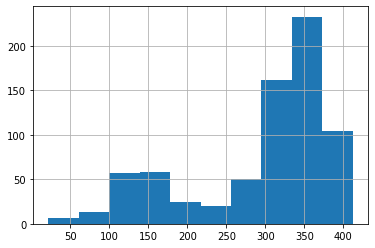

In [61]:
plotdf['canopy_height'].hist()

## Fit Models to the Season 4 extraction

In [62]:
import sklearn
import pandas as pd

In [63]:
# paste code from another notebook that uses 'cdf' as the source dataframe.  It 
# is easier to just copy to that same variable name
cdf = full_df

In [64]:
cdf.head()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,date,day_offset
2017-05-13 12:00:00,15.0,PI453696,4,43,2,0.435924,2.695956,1.977380,1.756464,2017-05-13 12:00:00,12
2017-05-13 12:00:00,15.0,PI145626,4,35,15,0.396782,3.265980,2.018623,1.941012,2017-05-13 12:00:00,12
2017-05-13 12:00:00,19.0,PI257600,4,42,2,0.471944,2.159610,1.809209,1.638744,2017-05-13 12:00:00,12
2017-05-13 12:00:00,13.0,PI569416,4,30,4,0.444099,3.042180,2.198751,1.732985,2017-05-13 12:00:00,12
2017-05-15 12:00:00,17.0,PI585454,4,45,2,0.462600,2.305345,1.872028,1.665387,2017-05-15 12:00:00,14


In [65]:
train_df = cdf[['day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']]
target_df = cdf['canopy_height']

In [66]:
train_df.head()

,day_offset,range,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean
2017-05-13 12:00:00,12,43,2,2.695956,1.977380,1.756464,0.435924
2017-05-13 12:00:00,12,35,15,3.265980,2.018623,1.941012,0.396782
2017-05-13 12:00:00,12,42,2,2.159610,1.809209,1.638744,0.471944
2017-05-13 12:00:00,12,30,4,3.042180,2.198751,1.732985,0.444099
2017-05-15 12:00:00,14,45,2,2.305345,1.872028,1.665387,0.462600


In [67]:
X_train = train_df.values
y_train = target_df.values
print(X_train.shape)
print(y_train.shape)

(9441, 7)
(9441,)


Below we are fitting  XGBoost, decision tree, and a linear model to the observed tuples in the "full" dataframe, which is canopy_height and leaf measurements.  We then get the results out and append them to the columns in the dataframe, so we can generate error terms and plot the results 

In [68]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor

tree = DecisionTreeRegressor(max_depth=8).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)
#svm_mod = svm.SVR().fit(X_train, y_train)
gbr_mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0, loss='ls').fit(X_train, y_train)

pred_tree = tree.predict(X_train)
pred_lr = linear_reg.predict(X_train)
#pred_svm = svm_mod.predict(X_train)
pred_gbr = gbr_mod.predict(X_train)


In [69]:
# add the results columns to the input data
cdf['cultivar'] = full_df['cultivar']
cdf['decision_tree'] = pred_tree
cdf['linearRegression'] = pred_lr
#cdf['svm'] = pred_svm
cdf['single_xgboost'] = pred_gbr
cdf.head()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,date,day_offset,decision_tree,linearRegression,single_xgboost
2017-05-13 12:00:00,15.0,PI453696,4,43,2,0.435924,2.695956,1.977380,1.756464,2017-05-13 12:00:00,12,20.684211,42.392578,18.350263
2017-05-13 12:00:00,15.0,PI145626,4,35,15,0.396782,3.265980,2.018623,1.941012,2017-05-13 12:00:00,12,16.200000,49.992035,15.788623
2017-05-13 12:00:00,19.0,PI257600,4,42,2,0.471944,2.159610,1.809209,1.638744,2017-05-13 12:00:00,12,20.684211,47.234878,22.092549
2017-05-13 12:00:00,13.0,PI569416,4,30,4,0.444099,3.042180,2.198751,1.732985,2017-05-13 12:00:00,12,16.200000,45.215572,17.007568
2017-05-15 12:00:00,17.0,PI585454,4,45,2,0.462600,2.305345,1.872028,1.665387,2017-05-15 12:00:00,14,20.684211,51.286969,19.366635


This dataframe contains many time series measurements for different cultivars, so lets develop a routine to let us print out the series of a single cultivar and how the models fit it

In [70]:
print(len(cdf))
cdf.tail()


9441


,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,date,day_offset,decision_tree,linearRegression,single_xgboost
2017-07-04 12:00:00,271.0,PI154944,4,48,3,0.405739,2.668148,1.771867,1.910103,2017-07-04 12:00:00,64,250.071429,209.040501,263.942495
2017-07-04 12:00:00,268.0,PI329550,4,48,4,0.466432,1.961894,1.573487,1.722770,2017-07-04 12:00:00,64,265.345455,218.326219,268.183386
2017-07-04 12:00:00,274.0,PI569423,4,49,7,0.415079,3.069223,2.013949,1.869177,2017-07-04 12:00:00,64,265.345455,208.654289,267.892498
2017-07-04 12:00:00,262.0,PI255239,4,49,12,0.542211,1.109560,1.352693,1.389389,2017-07-04 12:00:00,64,283.750000,218.150613,263.778441
2017-07-04 12:00:00,245.0,Big_Kahuna,4,54,15,0.393302,4.107072,2.462428,1.925890,2017-07-04 12:00:00,64,238.500000,203.896273,243.621158


            canopy_height  decision_tree  single_xgboost  linearRegression
day_offset                                                                
35                   82.0     101.326087       95.483022        121.756582
36                   85.0     112.364964      103.076456        121.054794
38                  101.0     125.537815      107.454792        128.575645
39                  105.0     128.512821      113.358752        132.121466
40                  114.0     143.160000      124.861679        134.788933
45                  151.0     168.659722      159.598816        156.447763
46                  157.0     175.333333      166.499100        158.229310
55                  216.0     233.208791      221.964694        189.299681
56                  219.0     233.208791      224.417962        193.202730
57                  222.0     236.669355      230.368480        198.307504
58                  229.0     236.669355      234.503357        199.026110
61                  241.0

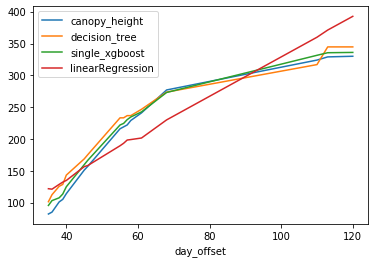

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_cultivar(fulldf,cultivar):
    df = fulldf.loc[fulldf['cultivar'] == cultivar]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    #print(df.shape)
    df = df[['day_offset','canopy_height','decision_tree','single_xgboost', 'linearRegression']]
    df = df.set_index('day_offset')
    df = df.sort_index()
    print(df)
    df.plot()
    for name, importance in zip(feature_names, gbr_mod.feature_importances_):
        print(name, "=", importance)

feature_names = ['day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']
plot_cultivar(cdf,'PI145619')


            canopy_height  decision_tree  single_xgboost  linearRegression
day_offset                                                                
35                   90.0     101.326087       92.534512        130.966181
36                  107.0     104.594203      105.222738        126.787203
40                  178.0     175.000000      175.251784        165.163584
45                  185.0     153.750000      177.445109        166.010864
56                  353.0     333.666667      323.054853        208.521558
57                  252.0     237.460993      251.036674        217.876115
58                  229.0     247.159574      248.601908        214.392485
day_offset = 0.9478850111886691
range = 0.01772626362085397
column = 0.01248368970060973
leaf_angle_alpha = 0.004524296532749082
leaf_angle_beta = 0.0060439683794846245
leaf_angle_chi = 0.005976463075005745
leaf_angle_mean = 0.00536030750262768


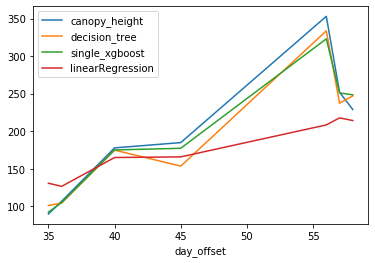

In [73]:
plot_cultivar(cdf,'PI569416')

In [74]:
cdf.head()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,date,day_offset,decision_tree,linearRegression,single_xgboost
2017-05-13 12:00:00,15.0,PI453696,4,43,2,0.435924,2.695956,1.977380,1.756464,2017-05-13 12:00:00,12,20.684211,42.392578,18.350263
2017-05-13 12:00:00,15.0,PI145626,4,35,15,0.396782,3.265980,2.018623,1.941012,2017-05-13 12:00:00,12,16.200000,49.992035,15.788623
2017-05-13 12:00:00,19.0,PI257600,4,42,2,0.471944,2.159610,1.809209,1.638744,2017-05-13 12:00:00,12,20.684211,47.234878,22.092549
2017-05-13 12:00:00,13.0,PI569416,4,30,4,0.444099,3.042180,2.198751,1.732985,2017-05-13 12:00:00,12,16.200000,45.215572,17.007568
2017-05-15 12:00:00,17.0,PI585454,4,45,2,0.462600,2.305345,1.872028,1.665387,2017-05-15 12:00:00,14,20.684211,51.286969,19.366635


Let's plot the whole field and show how the different models estimated the canopy_height

In [75]:
# calculate the percentage error between the actual and the model
cdf['abserror_gboost'] = 100.0*abs(cdf['canopy_height']-cdf['single_xgboost'])/cdf['canopy_height']
cdf['abserror_decision_tree'] = 100.0*abs(cdf['canopy_height']-cdf['decision_tree'])/cdf['canopy_height']
cdf['abserror_linearRegression'] = 100.0*abs(cdf['canopy_height']-cdf['linearRegression'])/cdf['canopy_height']
cdf.head()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,date,day_offset,decision_tree,linearRegression,single_xgboost,abserror_gboost,abserror_decision_tree,abserror_linearRegression
2017-05-13 12:00:00,15.0,PI453696,4,43,2,0.435924,2.695956,1.977380,1.756464,2017-05-13 12:00:00,12,20.684211,42.392578,18.350263,22.335084,37.894737,182.617185
2017-05-13 12:00:00,15.0,PI145626,4,35,15,0.396782,3.265980,2.018623,1.941012,2017-05-13 12:00:00,12,16.200000,49.992035,15.788623,5.257488,8.000000,233.280237
2017-05-13 12:00:00,19.0,PI257600,4,42,2,0.471944,2.159610,1.809209,1.638744,2017-05-13 12:00:00,12,20.684211,47.234878,22.092549,16.276575,8.864266,148.604623
2017-05-13 12:00:00,13.0,PI569416,4,30,4,0.444099,3.042180,2.198751,1.732985,2017-05-13 12:00:00,12,16.200000,45.215572,17.007568,30.827446,24.615385,247.812089
2017-05-15 12:00:00,17.0,PI585454,4,45,2,0.462600,2.305345,1.872028,1.665387,2017-05-15 12:00:00,14,20.684211,51.286969,19.366635,13.921383,21.671827,201.688053


In [76]:
cdf.tail()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,date,day_offset,decision_tree,linearRegression,single_xgboost,abserror_gboost,abserror_decision_tree,abserror_linearRegression
2017-07-04 12:00:00,271.0,PI154944,4,48,3,0.405739,2.668148,1.771867,1.910103,2017-07-04 12:00:00,64,250.071429,209.040501,263.942495,2.604245,7.722720,22.863284
2017-07-04 12:00:00,268.0,PI329550,4,48,4,0.466432,1.961894,1.573487,1.722770,2017-07-04 12:00:00,64,265.345455,218.326219,268.183386,0.068428,0.990502,18.534993
2017-07-04 12:00:00,274.0,PI569423,4,49,7,0.415079,3.069223,2.013949,1.869177,2017-07-04 12:00:00,64,265.345455,208.654289,267.892498,2.229015,3.158593,23.848800
2017-07-04 12:00:00,262.0,PI255239,4,49,12,0.542211,1.109560,1.352693,1.389389,2017-07-04 12:00:00,64,283.750000,218.150613,263.778441,0.678794,8.301527,16.736407
2017-07-04 12:00:00,245.0,Big_Kahuna,4,54,15,0.393302,4.107072,2.462428,1.925890,2017-07-04 12:00:00,64,238.500000,203.896273,243.621158,0.562793,2.653061,16.777031


look at a single cultivar, just to remember that we have a measurement for a number of times throughout the growing season.  We do that by filtering for a particular cultivar's value from the source dataframe.

In [77]:
print('this cultivar has ',len(cdf.loc[cdf['cultivar']=='PI154944']),'measurements.  Showing just a few:')
cdf.loc[cdf['cultivar']=='PI154944'].tail()

this cultivar has  33 measurements.  Showing just a few:


,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,date,day_offset,decision_tree,linearRegression,single_xgboost,abserror_gboost,abserror_decision_tree,abserror_linearRegression
2017-08-16 12:00:00,371.0,PI154944,4,15,12,0.443557,1.859897,1.424196,1.822238,2017-08-16 12:00:00,107,339.307229,360.859731,356.342080,3.950922,8.542526,2.733226
2017-08-17 12:00:00,369.0,PI154944,4,15,12,0.461108,1.707024,1.408425,1.743728,2017-08-17 12:00:00,108,339.307229,363.149889,361.490474,2.035102,8.046821,1.585396
2017-06-24 12:00:00,239.0,PI154944,4,48,3,0.476124,1.122113,1.100930,1.833578,2017-06-24 12:00:00,54,228.666667,209.044214,230.793629,3.433628,4.323570,12.533802
2017-07-08 12:00:00,283.0,PI154944,4,15,12,0.390424,2.959880,1.734316,2.060349,2017-07-08 12:00:00,68,273.623229,240.293461,275.870558,2.519238,3.313346,15.090650
2017-07-04 12:00:00,271.0,PI154944,4,48,3,0.405739,2.668148,1.771867,1.910103,2017-07-04 12:00:00,64,250.071429,209.040501,263.942495,2.604245,7.722720,22.863284


In [78]:
print('this cultivar has ',len(cdf.loc[cdf['cultivar']=='SP1615']),'measurements.  Showing just a few:')
cdf.loc[cdf['cultivar']=='SP1615'].tail()

this cultivar has  45 measurements.  Showing just a few:


,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,date,day_offset,decision_tree,linearRegression,single_xgboost,abserror_gboost,abserror_decision_tree,abserror_linearRegression
2017-08-17 12:00:00,326.0,SP1615,4,22,16,0.489375,1.047446,1.082874,1.676283,2017-08-17 12:00:00,108,352.060606,371.014313,334.718797,2.674478,7.994051,13.808071
2017-08-19 12:00:00,335.0,SP1615,4,53,9,0.458386,2.064851,1.635807,1.712225,2017-08-19 12:00:00,110,330.673913,356.672209,338.089205,0.922151,1.291369,6.469316
2017-06-24 12:00:00,210.0,SP1615,4,53,9,0.380999,3.687919,1.971168,2.102077,2017-06-24 12:00:00,54,208.500000,189.486052,217.930626,3.776489,0.714286,9.768546
2017-07-08 12:00:00,264.0,SP1615,4,53,9,0.459505,1.882542,1.509251,1.742443,2017-07-08 12:00:00,68,277.083333,230.676700,273.725179,3.683780,4.955808,12.622462
2017-07-04 12:00:00,247.0,SP1615,4,54,7,0.420763,2.610702,1.711088,1.917781,2017-07-04 12:00:00,64,265.345455,218.737851,254.564099,3.062388,7.427310,11.442166


In order to plot across the field when we have a series of measurments in time, we need to group the measurements together by cultivar and location.  Each group will consist of all the measurements taken at that location across time.  

In [79]:
import numpy as np
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = cdf.groupby(['cultivar','column','range']) 

In [80]:
print(grouped['abserror_gboost'].agg(np.mean))

cultivar          column  range
Big_Kahuna        2       53       4.049291
                          54       1.145764
                  4       53       1.926653
                          54       3.537828
                  6       54       1.801595
                                     ...   
SP1615            16      45       4.684397
                          51       9.227893
                          54       1.072601
Unknown off type  10      32       5.814204
                  14      9        7.323122
Name: abserror_gboost, Length: 727, dtype: float64


### gradient boost accuracy

In [81]:
import numpy as np

plotlist = []
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = cdf.groupby(['cultivar','column','range'])
for name,group in grouped:
    mark = {}
    mark['cultivar'] = name[0]
    mark['range'] = name[2]
    mark['column'] = name[1]
    mark['avg_error'] = group['abserror_gboost'].agg(np.mean)
    plotlist.append(mark)
    #print(mark)
print(plotlist[0])

{'cultivar': 'Big_Kahuna', 'range': 53, 'column': 2, 'avg_error': 4.0492914757647265}


In [82]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()

,cultivar,range,column,avg_error
0,Big_Kahuna,53,2,4.049291
1,Big_Kahuna,54,2,1.145764
2,Big_Kahuna,53,4,1.926653
3,Big_Kahuna,54,4,3.537828
4,Big_Kahuna,54,6,1.801595


This diagram is 50% overplotted, since each cultivar is planted twice in the plot.  We are only plotting one entry per field plot unit, but there are actually 2 plants in each unit.  

In [83]:
import altair as alt
alt.Chart(plotdf,title='Season4 - single model, error: gboost').mark_rect().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Avg Err %'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)

In [84]:

alt.Chart(plotdf,title="Histogram of error (in percent) of a single model ").mark_bar().encode(
    alt.X("avg_error:Q", bin=True),
    y='count()',
)

alt.Chart(...)

In [86]:

alt.Chart(plotdf,title="Histogram of error (in percent) of a single model: xgboost ").mark_bar().encode(
    alt.X("avg_error:Q", bin=alt.Bin(maxbins=50)),
    y='count()',
)

alt.Chart(...)

### linear regression accuracy

In [87]:
import numpy as np

plotlist = []
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = cdf.groupby(['cultivar','column','range'])
for name,group in grouped:
    mark = {}
    mark['cultivar'] = name[0]
    mark['range'] = name[2]
    mark['column'] = name[1]
    mark['avg_error'] = group['abserror_linearRegression'].agg(np.mean)
    plotlist.append(mark)
    #print(mark)
print(plotlist[0])

{'cultivar': 'Big_Kahuna', 'range': 53, 'column': 2, 'avg_error': 5.682170039122417}


In [88]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()

,cultivar,range,column,avg_error
0,Big_Kahuna,53,2,5.682170
1,Big_Kahuna,54,2,6.247462
2,Big_Kahuna,53,4,3.966388
3,Big_Kahuna,54,4,0.612239
4,Big_Kahuna,54,6,44.950733


In [89]:
import altair as alt
alt.Chart(plotdf,title='Season4 - single model, error: linear regression').mark_rect().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Avg Err %'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)

In [90]:

alt.Chart(plotdf,title="Histogram of error (in percent) of a single model: linearRegression ").mark_bar().encode(
    alt.X("avg_error:Q", bin=True),
    y='count()',
)

alt.Chart(...)

In [91]:

alt.Chart(plotdf,title="Histogram of error (in percent) of a single model: linearRegression ").mark_bar().encode(
    alt.X("avg_error:Q", bin=alt.Bin(maxbins=50)),
    y='count()',
)


alt.Chart(...)

### single model, decision tree

In [92]:
import numpy as np

plotlist = []
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = cdf.groupby(['cultivar','column','range'])
for name,group in grouped:
    mark = {}
    mark['cultivar'] = name[0]
    mark['range'] = name[2]
    mark['column'] = name[1]
    mark['avg_error'] = group['abserror_decision_tree'].agg(np.mean)
    plotlist.append(mark)
    #print(mark)
print(plotlist[0])

{'cultivar': 'Big_Kahuna', 'range': 53, 'column': 2, 'avg_error': 8.931082981715894}


In [93]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()

,cultivar,range,column,avg_error
0,Big_Kahuna,53,2,8.931083
1,Big_Kahuna,54,2,7.114846
2,Big_Kahuna,53,4,1.904128
3,Big_Kahuna,54,4,16.310226
4,Big_Kahuna,54,6,4.273351


In [94]:
import altair as alt
alt.Chart(plotdf,title='Season4 - single model, error: decision tree').mark_rect().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Avg Err %'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)

In [95]:

alt.Chart(plotdf,title="Histogram of error (in percent) decision tree").mark_bar().encode(
    alt.X("avg_error:Q", bin=True),
    y='count()',
)

alt.Chart(...)

In [96]:

alt.Chart(plotdf,title="Histogram of error (in percent) of a single model: decision tree ").mark_bar().encode(
    alt.X("avg_error:Q", bin=alt.Bin(maxbins=50)),
    y='count()',
)

alt.Chart(...)

#### Train a model for each cultivar in its location.  

A single model applied to all cultivars across the field can't fit perfectly because of the genetic and positional variation (one assumes). so generate separate models for each location in the field.  Do this by using groupby in pandas to create a separate group for each cultivar at a particular location.  Then we will build an retain a set of group-specific models. This cell takes a few minutes because of the large number of models being created.  We are doing evil indexing in Pandas here, so a TON of warnings are generated.  Let us temporarily mute the warnings, shall we, then we can re-enable them afterwards. 

In [97]:
import warnings
warnings.filterwarnings(action='ignore')


In [98]:
%%time
gbr_models = {}
predictions = {}
count = 0
grouped = full_df.groupby(['cultivar','column','range'])
for name,group in grouped:
    #print(name)
    # pick the features to use for training
    train_df = group[['day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']]
    # identify the 'target' feature to try to predict
    target_df = group['canopy_height']
    X_train = train_df.values
    y_train = target_df.values
    # train a model for this cultivar in this location and store the trained model in a dictionary
    gbr_models[name] = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0, loss='ls').fit(X_train, y_train)
    gbr_pred = gbr_models[name].predict(X_train)
    count += 1
    # add the model results back into the dataframe so we can plot the actual and predicted against all the indepedent variables
    train_df['gboost'] = gbr_pred
    #put the actual target value back in the dataframe so we can plot results
    train_df['canopy_height'] = target_df
    # store the predicted results in the same dictionary organization and the trained models
    predictions[name] = train_df
    if (count % 100) == 0:
        print('in process:',count, 'models')
print('finished generating',count,'models')

in process: 100 models
in process: 200 models
in process: 300 models
in process: 400 models
in process: 500 models
in process: 600 models
in process: 700 models
finished generating 727 models
CPU times: user 21 s, sys: 256 ms, total: 21.3 s
Wall time: 21.4 s


In [99]:
# re-enable warnings
warnings.filterwarnings(action='once')

In [100]:

for count,key in enumerate(predictions):
    print(key,count)
    if count >25:
        break

('Big_Kahuna', 2, 53) 0
('Big_Kahuna', 2, 54) 1
('Big_Kahuna', 4, 53) 2
('Big_Kahuna', 4, 54) 3
('Big_Kahuna', 6, 54) 4
('Big_Kahuna', 8, 54) 5
('Big_Kahuna', 10, 54) 6
('Big_Kahuna', 12, 54) 7
('Big_Kahuna', 14, 2) 8
('Big_Kahuna', 14, 54) 9
('Big_Kahuna', 15, 54) 10
('PI144134', 13, 29) 11
('PI144134', 15, 10) 12
('PI145619', 6, 27) 13
('PI145619', 8, 33) 14
('PI145626', 4, 3) 15
('PI145626', 15, 35) 16
('PI145633', 3, 51) 17
('PI145633', 8, 18) 18
('PI146890', 6, 35) 19
('PI146890', 13, 16) 20
('PI152591', 13, 25) 21
('PI152591', 15, 37) 22
('PI152651', 7, 16) 23
('PI152651', 11, 35) 24
('PI152694', 8, 7) 25
('PI152694', 11, 37) 26


In [101]:
# look at the output dataframe of one cultivar,column,range tuple
predictions[('Big_Kahuna', 2, 53)]

,day_offset,range,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,gboost,canopy_height
2017-06-10 12:00:00,40,53,2,6.446399,2.440049,2.558845,0.286448,158.0,158.0


In [102]:
# look at the output dataframe of another cultivar,column,range tuple
predictions[('PI145619', 8, 33)]

,day_offset,range,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,gboost,canopy_height
2017-05-20 12:00:00,19,33,8,3.183700,2.005894,1.921478,0.401014,21.004905,21.0
2017-05-25 12:00:00,24,33,8,2.980092,1.996341,1.844534,0.419530,36.004298,36.0
2017-06-02 12:00:00,32,33,8,4.340498,2.255889,2.133238,0.352648,84.003039,84.0
2017-06-03 12:00:00,33,33,8,3.461628,2.059197,1.972155,0.392636,74.003737,74.0
2017-06-04 12:00:00,34,33,8,3.046362,1.966913,1.899743,0.409137,75.003110,75.0
2017-07-11 12:00:00,71,33,8,2.406729,1.822888,1.734302,0.448542,281.997806,282.0
2017-07-05 12:00:00,65,33,8,1.446854,1.340827,1.666626,0.481166,266.998113,267.0
2017-08-10 12:00:00,101,33,8,2.357006,1.714665,1.793166,0.442961,323.996552,324.0
2017-07-06 12:00:00,66,33,8,2.833245,1.955855,1.770764,0.448582,265.998456,266.0
2017-07-03 12:00:00,63,33,8,1.741045,1.567223,1.621842,0.477730,251.998668,252.0


Define a variation of the plotting routine that retrieves values from the trained model's predictions and compares them to the original observed values.  

In [103]:

def plot_specific_cultivar(cultivar,col,rng):
    df = predictions[(cultivar,col,rng)]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    print(df.shape)
    df = df[['day_offset','canopy_height','gboost']]
    df = df.set_index('day_offset')
    df = df.sort_index()
    print(df)
    df.plot()

(5, 9)
            canopy_height      gboost
day_offset                           
15                   24.0   24.006098
58                  235.0  235.000494
107                 329.0  328.998019
108                 329.0  328.998019
113                 351.0  350.997370


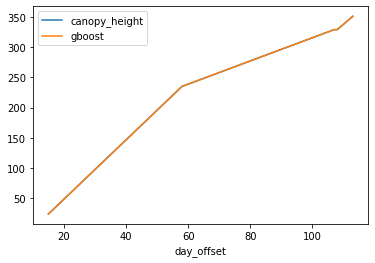

In [104]:
plot_specific_cultivar('Big_Kahuna', 8, 54)

(16, 9)
            canopy_height      gboost
day_offset                           
35                   82.0   82.003342
36                   85.0   85.002820
38                  101.0  101.002713
39                  105.0  105.002502
40                  114.0  114.002098
45                  151.0  151.001505
46                  157.0  157.000878
55                  216.0  215.999782
56                  219.0  218.999413
57                  222.0  221.999296
58                  229.0  228.999181
61                  241.0  240.998806
68                  277.0  276.997925
110                 324.0  323.996942
113                 329.0  328.996594
120                 330.0  329.996202


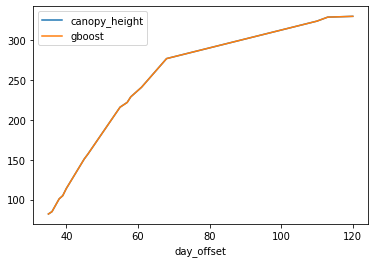

In [105]:
plot_specific_cultivar('PI145619', 6, 27)

**the above plots show that a gradient boost model can precisely fit the observed data when trained on only the particular cultivar and location measurements.** This isn't too much of a surprise.  It shows that a single model for the whole field  can't match as well (at least when using the cultivar as an integer variable).  Ideally, we should have one-hot encoded the cultivar as a categorical variable. 

How to find the feature importances.  This is an output of the trained model. Lets look at one before we add it to the plot

In [106]:
feature_names = ['day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']
for name, importance in zip(feature_names, gbr_models[('PI145619', 6, 27)].feature_importances_):
    print(name, "=", importance)

day_offset = 0.9938809752982937
range = 0.0
column = 0.0
leaf_angle_alpha = 0.002238821340799633
leaf_angle_beta = 0.001470342178861396
leaf_angle_chi = 0.002015525200836983
leaf_angle_mean = 0.00039433598120829143


Unsurprisingly, the day, which represents how far into the growing season we are, is by far (98%) the most driving factor of calculating the model result.

In [107]:

def plot_specific_cultivar(cultivar,col,rng):
    feature_names = ['day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']
    df = predictions[(cultivar,col,rng)]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    print(df.shape)
    df = df[['day_offset','canopy_height','gboost']]
    df = df.set_index('day_offset')
    df = df.sort_index()
    print(df)
    df.plot()
    for name, importance in zip(feature_names, gbr_models[(cultivar,col,rng)].feature_importances_):
        print(name, "=", importance)

(16, 9)
            canopy_height      gboost
day_offset                           
35                   82.0   82.003342
36                   85.0   85.002820
38                  101.0  101.002713
39                  105.0  105.002502
40                  114.0  114.002098
45                  151.0  151.001505
46                  157.0  157.000878
55                  216.0  215.999782
56                  219.0  218.999413
57                  222.0  221.999296
58                  229.0  228.999181
61                  241.0  240.998806
68                  277.0  276.997925
110                 324.0  323.996942
113                 329.0  328.996594
120                 330.0  329.996202
day_offset = 0.9938809752982937
range = 0.0
column = 0.0
leaf_angle_alpha = 0.002238821340799633
leaf_angle_beta = 0.001470342178861396
leaf_angle_chi = 0.002015525200836983
leaf_angle_mean = 0.00039433598120829143


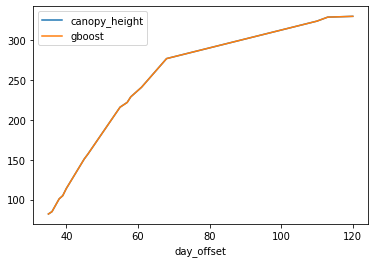

In [108]:
plot_specific_cultivar('PI145619', 6, 27)

In [109]:
import numpy as np

count = 0
plotlist = []
for key in predictions.keys():
    mark = {}
    mark['cultivar'] = key[0]
    mark['range'] = key[2]
    mark['column'] = key[1]
    df = predictions[key]
    df['abserror_gboost'] = 100.0*abs(df['canopy_height']-df['gboost'])/df['canopy_height']
    mark['avg_error'] = df['abserror_gboost'].agg(np.mean)
    plotlist.append(mark)
    count += 1
        
print(plotlist[0:5])

[{'cultivar': 'Big_Kahuna', 'range': 53, 'column': 2, 'avg_error': 0.0}, {'cultivar': 'Big_Kahuna', 'range': 54, 'column': 2, 'avg_error': 0.0}, {'cultivar': 'Big_Kahuna', 'range': 53, 'column': 4, 'avg_error': 0.0006949919758262705}, {'cultivar': 'Big_Kahuna', 'range': 54, 'column': 4, 'avg_error': 0.0}, {'cultivar': 'Big_Kahuna', 'range': 54, 'column': 6, 'avg_error': 0.007508108564964144}]


/Users/curtislisle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [110]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()
len(plotdf)

727

In [204]:
import altair as alt
alt.Chart(plotdf, title="Season4 - model per location").mark_rect().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Avg Err %'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)

In [112]:

alt.Chart(plotdf,title="Histogram of error (in percent) per location model").mark_bar().encode(
    alt.X("avg_error:Q", bin=True),
    y='count()',
)

alt.Chart(...)

These diagrams above show that fitting a model for *each location* of the field (which is overkill), fits the growth exactly.  This removes the need for the models to generalize over genetic variation.  

We will go through the dictionary entries now and convert the per-location model results to a single dataframe, so it can be merged back together with the source measurements and the other data. 

In [113]:
firstTime = True

# go through each cultivar
for key in predictions.keys():
    this_df = predictions[key]
    # add cultivar name to measurements dataframe
    this_df['cultivar'] = key[0]
    # now add these lines to the output
    if firstTime:
        per_location_df = this_df
        firstTime = False
    else:
        per_location_df = per_location_df.append(this_df,ignore_index=True)
    
    

/Users/curtislisle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [114]:
print(per_location_df.shape)
per_location_df.head()

(9441, 11)


,day_offset,range,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,gboost,canopy_height,abserror_gboost,cultivar
0,40,53,2,6.446399,2.440049,2.558845,0.286448,158.000000,158.0,0.000000,Big_Kahuna
1,116,54,2,2.994599,1.832073,1.961031,0.410766,357.000000,357.0,0.000000,Big_Kahuna
2,110,53,4,1.970067,1.684796,1.644160,0.472598,336.998234,337.0,0.000524,Big_Kahuna
3,54,53,4,3.479814,1.781956,2.229401,0.366545,204.001766,204.0,0.000866,Big_Kahuna
4,33,54,4,4.775740,2.310997,2.209762,0.342345,113.000000,113.0,0.000000,Big_Kahuna


In [115]:
per_location_df = per_location_df.rename(columns={'gboost': 'per_location_gboost','abserror_gboost': 'abserror_per_location_gboost'})

In [116]:
per_location_df.tail()

,day_offset,range,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,per_location_gboost,canopy_height,abserror_per_location_gboost,cultivar
9436,39,32,10,3.506227,1.948681,2.082183,0.380423,135.999275,136.0,0.000533,Unknown off type
9437,40,32,10,3.036119,1.831445,2.013121,0.389597,147.998826,148.0,0.000793,Unknown off type
9438,19,9,14,4.084993,2.389530,1.942445,0.394678,30.001930,30.0,0.006434,Unknown off type
9439,34,9,14,4.295035,2.277602,2.102187,0.356882,93.000257,93.0,0.000276,Unknown off type
9440,45,9,14,3.408733,1.970234,2.020684,0.389385,184.997813,185.0,0.001182,Unknown off type


In [117]:
per_location_df.to_csv('s4_per_location_gboost.csv')

In [207]:
import pandas as pd
per_location_df=pd.read_csv('s4_per_location_gboost.csv')

The OPEN program asked for a confusion matrix based on cultivar.  Lets use this season4 dataframe to generate one. First, we will plot the max height by iterating through the dataframe

In [208]:
%%time
plotlist = []
count = 0
grouped = per_location_df.groupby(['cultivar'])
for name,group in grouped:
    mark = {}
    mark['cultivar'] = name
    mark['canopy_height'] = group['canopy_height'].agg(np.max)
    plotlist.append(mark)
    #print(mark)
print(plotlist[0])
print(len(plotlist))
cultivars_df = pd.DataFrame(plotlist)

{'cultivar': 'Big_Kahuna', 'canopy_height': 364.0}
351
CPU times: user 147 ms, sys: 15.1 ms, total: 162 ms
Wall time: 171 ms


Now we have a dataframe (cultivars_df) which is the diagonal of the confusion matrix.  Each measurement is the max canopy_height reached during the season.  We want to fill in a matrix by iterating across the cultivars and filling in the differences between each final height to complete a matrix. 

In [177]:
#cultivars_df.set_index('cultivar',inplace=True)
print(cultivars_df.loc[cultivars_df['cultivar']=='Big_Kahuna']['canopy_height'])
print(cultivars_df.loc[cultivars_df['cultivar']=='PI144134']['canopy_height'])


0    364.0
Name: canopy_height, dtype: float64
1    327.0
Name: canopy_height, dtype: float64


In [212]:
%%time
# get a list of the cultivars to iterate. A random sample is picked to reduce the matrix
sampleSize = 25
plotlist = []
count = 0
cultivars = cultivars_df.sample(sampleSize)['cultivar']
for cult in cultivars:
    cult1height = (cultivars_df.loc[cultivars_df['cultivar']==cult]['canopy_height'])
    #print((cult1height.iloc(0)))
    #print('cult1 is',cult)
    for cult2 in cultivars:
        #print('cult2 is',cult2)
        cult2height = (cultivars_df.loc[cultivars_df['cultivar']==cult2]['canopy_height'])
        #print(cult2height)
        #print(cult2height[1])
        mark = {}
        mark['cultivar1'] = cult
        mark['cultivar2'] = cult2
        mark['difference'] = abs(cult1height.iloc[0] - cult2height.iloc[0])
        plotlist.append(mark)
        count += 1
        #if (count > 100):
        #        break
        if (count % 10000) == 0:
            print(count)
print(plotlist[0])
print(len(plotlist))

{'cultivar1': 'PI569148', 'cultivar2': 'PI569148', 'difference': 0.0}
625
CPU times: user 449 ms, sys: 24.3 ms, total: 474 ms
Wall time: 472 ms


In [213]:
plot_df = pd.DataFrame(plotlist)
sample_df = plot_df
sample_df.head()

,cultivar1,cultivar2,difference
0,PI569148,PI569148,0.0
1,PI569148,PI229841,14.0
2,PI569148,PI329299,10.0
3,PI569148,PI642998,18.0
4,PI569148,PI570114,282.0


In [214]:
import altair as alt
alt.Chart(sample_df, title="Season4 - canopy height").mark_rect().encode(
    x='cultivar1:O',
    y='cultivar2:O',
    color='difference:Q',
    tooltip=[
        alt.Tooltip('difference:Q', title='Difference'),
        alt.Tooltip('cultivar1:O', title='Cultivar1'),
        alt.Tooltip('cultivar2:O', title='Cultivar2'),
    ]
)

alt.Chart(...)

### Exploring treatments and other subtle features in the raw data

In [3]:
# we will use this function later in the notebook
def returnUniqueCounts(dframe):
    return pd.DataFrame.from_records([(col, dframe[col].nunique()) for col in dframe.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

In [2]:
import pandas as pd
s4_df = pd.read_csv('/Users/curtislisle/Dropbox/ipython-notebooks/D3M/TERRA/terraref_r/season4date.csv')

/Users/curtislisle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (18,32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
returnUniqueCounts(s4_df)

,Column_Name,Num_Unique
30,statname,0
29,n,0
31,stat,0
11,scientificname,1
1,checked,1
2,result_type,1
24,dateloc,1
8,city,1
14,species_id,1
23,year,1


In [6]:
s4_df['treatment'].unique()

array([nan, 'BAP 2017, water-deficit stress Aug 1-14',
       'BAP 2017, water-deficit stress Aug 15-30'], dtype=object)

(see above) so there was water-defecit during August.  Did this have an effect on the slope of growth during the year? Can we see an effect on the plants between August 1 and August 30? 

In [11]:
s4_df.shape

(372363, 40)